<a href="https://colab.research.google.com/github/Putragaol/PutraHutagaol.github.io/blob/main/Google_Causal_Impact_Volkswagen_CO2_Scandal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case

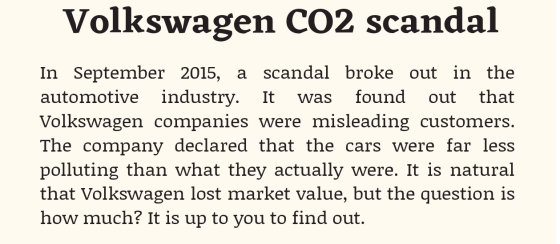

Use Causal Impact to measure the impact of the CO2 scandal in Volkswagen stock price

1.   Pick Stocks for the control groups
2.   Perform a correlation matrix
3.   Measure the impact

#Libraries, Dates and Data

In [ ]:
#Installing libraries
!pip install yfinance
!pip install tfcausalimpact

In [ ]:
#import libraries
import yfinance as yf  #For download the stock data

The treatment is around September 2015.

In [ ]:
#Dates
training_start = '2014-01-08'
training_end = '2015-08-26'
treatment_start = '2015-09-02'
treatment_end = '2015-09-30'
end_stock = '2015-10-02'

In [ ]:
#Download VW stock
y = ['VOW.DE']
y = yf.download(tickers = y,
                start = training_start,
                end = end_stock,
                interval = '1wk')
y = y['Adj Close'].rename('y')
y.head(3)

[*********************100%%**********************]  1 of 1 completed


Date
2014-01-06    133.480164
2014-01-13    135.158096
2014-01-20    126.700043
Name: y, dtype: float64

In [ ]:
#Import more libraries
import pandas as pd
from causalimpact import CausalImpact
import seaborn as sns                     #we use this to show the correlation heatmap between the stock data
import matplotlib.pyplot as plt           #To plot the impact prediction of CO2

Let's specify some stocks

The most important thing is that it is stocks **not in the automotive industry**, because a scandal that hits automotive industry is bound to affect every singel player in the industry

In [ ]:
#Download the control groups
stocks = ['META', 'DIS', 'NVS', 'AMZ']  #meta, disney, novartis and amazone (we can add another stocks)
X =  yf.download(tickers = stocks,
                start = training_start,
                end = end_stock,
                interval = '1wk')
X = X.iloc[:, :len(stocks)]
X.columns = X.columns.droplevel()
X.head(2)

[*********************100%%**********************]  4 of 4 completed


,AMZ,DIS,META,NVS
Date,,,,
2014-01-06,290.200012,69.157242,57.939999,50.780766
2014-01-13,296.000000,67.863823,56.299999,50.680878


In [ ]:
#Combine everything
X.index = X.index.tz_localize(None)
df = pd.concat([y, X], axis = 1). dropna()
df.head(3)

,y,AMZ,DIS,META,NVS
Date,,,,,
2014-01-06,133.480164,290.200012,69.157242,57.939999,50.780766
2014-01-13,135.158096,296.000000,67.863823,56.299999,50.680878
2014-01-20,126.700043,287.000000,66.707993,54.450001,49.844315


#Correlation Matrix


In [ ]:
#Subset the training data
df_training = df[df.index <=training_end]
df_training.tail()

,y,AMZ,DIS,META,NVS
Date,,,,,
2015-07-13,144.946503,445.350006,111.061440,94.970001,70.214951
2015-07-27,131.610245,484.250000,112.126656,94.010002,68.847946
2015-08-10,128.714188,478.299988,100.129089,94.419998,68.005188
2015-08-17,117.988022,445.049988,92.354980,86.059998,64.740288
2015-08-24,121.920937,465.399994,95.756157,91.010002,65.264542


Check Weather the variables are correlated in the period, and Remove non-corelated data

<Axes: >

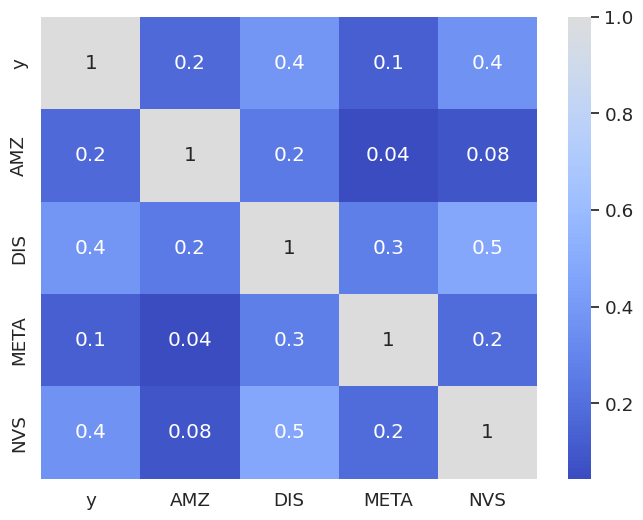

In [ ]:
#Heatmap
plt.figure(figsize = (8,6),)
sns.set(font_scale = 1.2)
sns.heatmap(data = df_training.pct_change().dropna().corr(),
            annot = True,
            fmt = '.1g',
            cmap = 'coolwarm',
            center = True,
            )

I always assume that < 0.3 is not corelated

The bigger the correlation, the better the model (Hint : we can add another stocks that have high correlation, but also not in Automotive industri)

In [ ]:
#Preparing final df
df_final = df.drop(columns = ['META', 'AMZ'])   #Remove the non-corelated variables
df_final.head(2)

,y,DIS,NVS
Date,,,
2014-01-06,133.480164,69.157242,50.780766
2014-01-13,135.158096,67.863823,50.680878


#Google causal impact

In [ ]:
#Get firts and last date
print(df_final.head(1))
print(df_final.tail(3))

                     y        DIS        NVS
Date                                        
2014-01-06  133.480164  69.157242  50.780766
                     y        DIS        NVS
Date                                        
2015-09-14  115.377975  96.092529  64.136421
2015-09-21   82.627365  93.719193  60.592827
2015-09-28   72.330231  96.242050  61.893475


In [ ]:
#Dates
training_start = '2014-01-06'
training_end = '2015-08-31'
treatment_start = '2015-09-07'
treatment_end = '2015-09-28'
end_stock = '2015-10-02'

In [ ]:
#Define Pre and Post Period
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]


Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


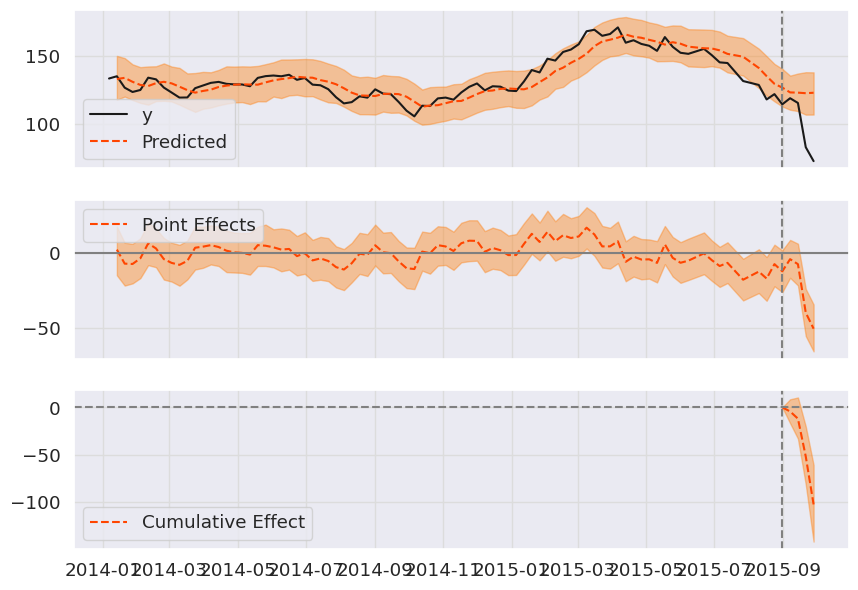

In [ ]:
#CI
impact = CausalImpact (data = df_final,
                       pre_period = pre_period,
                       post_period = post_period)
impact.plot()

In [ ]:
#summary
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    97.3               389.22
Prediction (s.d.)         122.94 (5.41)      491.76 (21.62)
95% CI                    [112.31, 133.5]    [449.25, 534.02]

Absolute effect (s.d.)    -25.63 (5.41)      -102.54 (21.62)
95% CI                    [-36.2, -15.01]    [-144.8, -60.03]

Relative effect (s.d.)    -20.85% (4.4%)     -20.85% (4.4%)
95% CI                    [-29.45%, -12.21%] [-29.45%, -12.21%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [ ]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 97.3. By contrast, in the absence of an
intervention, we would have expected an average response of 122.94.
The 95% interval of this counterfactual prediction is [112.31, 133.5].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -25.63 with a 95% interval of
[-36.2, -15.01]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 389.22.
By contrast, had the intervention not taken place, we would have expected
a sum of 491.76. The 95% interval of this prediction is [449.25, 534.02].


The above results are given in terms of absolute numbers. In relative
terms, the response var